## LDA

В той работе я взяла стихи Стефании Даниловой, в этой - посты из Чая со вкусом коммунальной квартиры. Мб еще для своих стихов так сделаю, если разберусь, как их из iCloud вытащить и обработать так, чтобы только стихи остались (без заметок, фанфиков и доп.файлов)

То, как вытаскивала тексты:

In [ ]:
import requests
import json


if __name__ == '__main__':
    vk_config = {"token": "",
                 "client_id": "",  # ID приложения
                 "version": "5.124",
                 "domain": "https://api.vk.com/method/"}
    posts_data = {}
    for i in range(3):
        req = requests.get(vk_config["domain"] + "wall.get", params={"access_token": vk_config["token"],
                                                                     "v": vk_config["version"],
                                                                     "account_id": vk_config["client_id"],
                                                                     "owner_id": -9073074,
                                                                     "offset": i * 100,
                                                                     "count": 100})
        data = req.json()["response"]["items"]
        temp = {}
        for j in range(len(data)):
            temp[j+i*100] = {"post_text": data[j]["text"]}
        posts_data.update(temp)

    with open("tea.json", "w", encoding='utf-8') as f:
        json.dump(posts_data, f, indent=4, ensure_ascii=False)


Всякие страшные импорты. Как блин сделать один capture на всё? А то такие простыни текста вылезают жуткие...

In [1]:
%%capture
!pip install pymorphy2
!pip install pyLDAvis
!pip install pandas==1.3.0

In [2]:
%%capture
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import pandas as pd
import re

nltk.download('stopwords')
nltk.download('punkt')
analyzer = pymorphy2.MorphAnalyzer()

Выгружаю тексты, как-то обрабатываю их чужим алгоритмом, принцип работы которого мне понятен очень смутно.

In [3]:
data = pd.read_json('/content/tea.json')

In [4]:
data = data.melt()

In [5]:
data.head(5)

,variable,value
0,0,уйди. \nя тебя не люблю. \n \nв асфальте тиши ...
1,1,февраль намерен превратиться в март:\nон сердо...
2,2,"они такие: читают Блока, \nиграют Шуберта, пью..."
3,3,"тронь меня — и ты тронешь сухой репей, \nсырос..."
4,4,"наша вечность сгорает в пламени, тлеет небо ве..."


Нужно будет написать функцию для обработки исходных текстов. Если в тексте меньше 8 переносов строк (слитные считаются за 1) - можно выбросить текст, скорее всего это не стихотворение


In [6]:
def text_to_wordlist(text, remove_stopwords=False):
    # оставляем только буквенные символы, удаляем нечто в скобках
    text = re.sub("[^а-яА-ЯёЁ]"," ", re.sub(r'\((.*?)\)', "", text)) # разберись с регулярками. текст в скобках нужен и важен
    # токенизируем текст и приводим к нижнему регистру
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    norm_words = [analyzer.parse(word)[0].normal_form for word in words]
    if remove_stopwords:
      # убираем стоп-слова
      stops = stopwords.words("russian") + ["твой", "эй", "это", "который", "наш", "мочь", "год", # надо поколдовать с этим, а еще лучше - составить свое
                                            "такой", "знать", "мы", "свой", "один", "другой", "хотеть",
                                            "человек", "всё", "весь", "очень", "думать", "нужно",
                                            "большой", "время", "использовать", "говорить", "сказать",
                                            "иметь", "сделать", "первый", "каждый", "день", "её", "ваш",
                                            "стать", "больший", "ваше", "день", "самый", "понять",
                                            "просто", "ещё", "проблема", "также", "например", "делать", "вещь", "хороший", "спасибо"]
      norm_words = [w for w in norm_words if w not in stops]
    return norm_words

In [7]:
data["preprocessed_text"] = data.apply(lambda poem: text_to_wordlist(poem['value'], remove_stopwords=True), axis=1)

In [8]:
data.head(5)

,variable,value,preprocessed_text
0,0,уйди. \nя тебя не люблю. \n \nв асфальте тиши ...,"[уйти, любить, асфальт, тиша, патовый, плохо, ..."
1,1,февраль намерен превратиться в март:\nон сердо...,"[февраль, намеренный, превратиться, март, серд..."
2,2,"они такие: читают Блока, \nиграют Шуберта, пью...","[читать, блок, играть, шуберт, пить, вино, поз..."
3,3,"тронь меня — и ты тронешь сухой репей, \nсырос...","[тронуть, тронуть, сухой, репей, сырость, прис..."
4,4,"наша вечность сгорает в пламени, тлеет небо ве...","[вечность, сгорать, пламя, тлеть, небо, весенн..."


In [9]:
all_words = []
for doc in data["preprocessed_text"].tolist():
  all_words.extend(doc)
#all_words = sorted(set([(word, all_words.count(word)) for word in all_words]), key=itemgetter(1), reverse=True)
len(all_words)

20393

Перейдем к созданию корпуса и построению модели.

In [10]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm

id2word = corpora.Dictionary(data["preprocessed_text"].tolist())
texts = data["preprocessed_text"].tolist()
corpus = [id2word.doc2bow(text) for text in texts] # что такое word2vec я знаю, но что ЭТО ТАКОЕ

In [11]:
print(corpus[2])

[(31, 1), (37, 1), (70, 2), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (116, 1), (117, 1), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (123, 1), (124, 1), (125, 1), (126, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 1), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 2), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 2), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1)]


Количество тем - тот параметр, который надо настраивать.

In [29]:
%%capture
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): # что происходит в этой функции я не понимаю от слова совсем
    """
	Подсчет c_v когерентности для различного количества тем
	dictionary : Gensim словарь
	corpus : Gensim корпус
	texts : Список текста
	limit : Максимальное количество тем
	
	model_list : Список LDA моделей
	coherence_values :Когерентности, соответствующие модели LDA с количеством тем
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	
# Вызовем функцию и посчитаем
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=1)

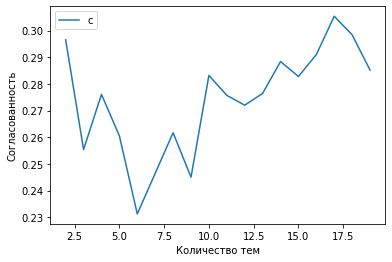

In [30]:
import matplotlib.pyplot as plt
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
n_topics = x[coherence_values.index(max(coherence_values))]
n_topics

17

Получилось 38 тем. 

In [36]:
%%capture
from gensim.models import LdaMulticore, CoherenceModel
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=10)

Выведем наиболее частотные ключевые слова каждой из тем.

In [37]:
lda_model.print_topics()

[(0,
  '0.006*"рука" + 0.006*"сон" + 0.004*"глаз" + 0.003*"ночь" + 0.003*"ребёнок" + 0.002*"слово" + 0.002*"жизнь" + 0.002*"жить" + 0.002*"пока" + 0.002*"лес"'),
 (1,
  '0.004*"принцесса" + 0.003*"жизнь" + 0.003*"сердце" + 0.003*"давать" + 0.002*"мир" + 0.002*"душа" + 0.002*"рука" + 0.002*"слово" + 0.002*"глаз" + 0.002*"лишь"'),
 (2,
  '0.004*"любовь" + 0.003*"сердце" + 0.003*"душа" + 0.003*"тишина" + 0.003*"идти" + 0.003*"принцесса" + 0.003*"глаз" + 0.002*"свет" + 0.002*"друг" + 0.002*"слово"'),
 (3,
  '0.005*"сердце" + 0.004*"жить" + 0.003*"мир" + 0.002*"любить" + 0.002*"город" + 0.002*"ночь" + 0.002*"лишь" + 0.002*"ветер" + 0.002*"небо" + 0.002*"рука"'),
 (4,
  '0.005*"рука" + 0.004*"слово" + 0.004*"друг" + 0.004*"сердце" + 0.003*"жизнь" + 0.003*"мир" + 0.003*"свет" + 0.003*"глаз" + 0.003*"хотеться" + 0.003*"лишь"'),
 (5,
  '0.006*"устать" + 0.006*"мама" + 0.005*"любить" + 0.004*"сердце" + 0.003*"лишь" + 0.003*"душа" + 0.003*"друг" + 0.003*"остаться" + 0.002*"жизнь" + 0.002*"почему"

Модуль `pyLDAvis` позволяет сделать интерактивную визуализацию результатов тематического моделирования.

In [38]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

In [39]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.039747 -0.018600       1        1  15.379770
2     -0.048225 -0.032463       2        1  12.445459
9     -0.012139 -0.009062       3        1  11.595994
4      0.006081 -0.001770       4        1  11.407991
5     -0.035033  0.026479       5        1  10.192197
0      0.009649 -0.047566       6        1   9.430284
3      0.044498  0.020807       7        1   8.662130
7     -0.002289  0.013448       8        1   8.300195
6     -0.011485  0.042649       9        1   7.137363
1      0.009196  0.006079      10        1   5.448616, topic_info=           Term       Freq      Total Category  logprob  loglift
1043       мама  19.000000  19.000000  Default  30.0000  30.0000
2868  принцесса  14.000000  14.000000  Default  29.0000  29.0000
59       устать  25.000000  25.000000  Default  28.0000  28.0000
1357  вселенная   9.000000   9.000000  Default  27.0000  27.0000
284        рука  63.000000  63.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
597        пока   1.405056  33.534195  Topic10  -6.6731  -0.2627
379     бояться   1.302340  20.885444  Topic10  -6.7490   0.1349
426        сила   1.267138  17.715530  Topic10  -6.7764   0.2721
23       любить   1.302622  50.688926  Topic10  -6.7488  -0.7515
46         свет   1.294265  39.154007  Topic10  -6.7552  -0.4998

[793 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1354      7  0.682224   абонемент
299       4  0.662681       аборт
6638      4  0.272556  абсолютный
6638      7  0.272556  абсолютный
3543      5  0.709228       айсин
...     ...       ...         ...
4996      9  0.351329           э
4457      8  0.675402    являться
6608      1  0.652593       якопо
6608      7  0.326296       якопо
5853     10  0.496279         яма

[1929 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 10, 5, 6, 1, 4, 8, 7, 2])

Хочу поиграться с количеством тем, оно мне совсем не нравится. Потому что в стихах обычно стандартные темы: любовь, страдания, поэт и поэзия, политика, опять страдания, предназначение человека, бытовуха. Еще иногда бывают стихи-анекдоты, стихи-где-все-хорошо. Согласна, что страдания можно разбить на множество подразделов, но можно ни нада...

In [ ]:
%%capture
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=30, step=1)

In [ ]:
import matplotlib.pyplot as plt
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
n_topics = x[coherence_values.index(max(coherence_values))]
n_topics

In [ ]:
%%capture
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

Несколько выводов, на которые наталкивает получившееся. 

Во-первых, в стоп-слова надо закинуть весь поэтический мусор (все, всё, твой, свой, союзы, предлоги, междометия, лишь, ведь, только + я еще посижу подумаю). Еще нужно выбросить числительные как в числовом, так и в буквенном представлении. Надо отбросить слишком короткие тексты, потому что я не ручаюсь, что в выборку не попали посты-цитатки. А еще определить, стихотворение ли перед нами, можно по количеству переносов строки. Оно должно быть не менее 8 на текст, потому что все, что меньше двух четверостиший, по моему мнению стихотворением можно назвать с натяжкой. Хотя тут может быть лажа с тем, что некоторые авторы принципиально не ставят переносы строк - тут остается только на рифмующиеся окончания слов смотреть, поэзия ж.

Нужно чистить каждый текст от повторов, но как-то маркировать их. В плане если в тексте слово "бессмысленность" встречается раз пять, то это либо поэт слабый, либо текст реально про бессмысленность (press F to pay respects). Можно ввести коэффициент "плотности" слова - сколько раз конкретное слово встретится относительно общего числа слов.

Иностранные слова! Они могут быть, и это не есть хорошо. Обычно так бывает, когда у автора рифмы кончились, или когда цитата очень красивая, но на русском не звучит. Если вдруг в тексте иностранных слов больше, чем русских - выбросить бы его. Он либо весь на иностранном, либо это русский в нем - иностранный. Я бы не стала выбрасывать иностранные слова, но ведь в таком случае переводчик нужен, так что ну его.

А еще, я так понимаю, при обработке с использованием функции Вадимовны мы теряем текст в скобках. Со стихами так поступать ни в коем случае нельзя!

Еще у нас есть какие-то подозрительные крохотные слова из одной-двух букв. Мне кажется, их надо выбросить, потому что они не несут никакого смысла.

Ну и в Чае все стихи подписываются, поэтому строчку, которая начинается с (с) необходимо удалять целиком.

И вообще какие-то очень неожиданные результаты получаются в целом. Не в плане "вау", а в плане "ну и что это за бред?"

Я кстати понятия не имею, зачем мне вся эта простыня. Зачем вообще трогать современную поэзию? Узнать, о чем люди пишут? Ну я это и без моделек програмистских знаю. Хотите, статью напишу в стиле "как Соня видит современную поэзию"? 

Вхыхыхы в коллабе тоже можно писать кривые стишки. Будем считать это рефлексией:

код чужой. непонятные правила.

слегка строчку поправила -

сиди, разбирайся с ошибкой.

обещаю себе не плакать. сижу с улыбкой.

истерической, к сожалению.

с днем тотального невезения!

с днем несделанной лабы,

сломавшегося коллаба

и на пол пары ушедшей Вадимовны.

когда пять из пятнадцати человек готовы расплакаться

из-за заданий, данных на практике.

обещаю стараться...

все каникулы заставляла себя учиться.

в голове - пустота. отчислят?..

но я не хочу!

только и делаю, что учусь.

"зубрилка и недотрога".

какой же кошмар эта прога! -

третий час не въезжаю -

и всё же... безумно, до одури обожаю